Dataset created with 52 molecules
First few rows:
        Name       MW     LogP  HBD  HBA  RB    TPSA  Label  Num_C  Num_H  \
0   42583265  474.985  5.44300    0    4   3   49.85      1     24      0   
1  164516813  498.590  4.05410    3    9   5  134.48      1     22      0   
2  165412710  371.466  1.80692    2    7   4   84.89      1     18      0   
3  169450430  479.540  5.27130    1    8   7   97.31      1     28      0   
4  169450172  373.412  5.29270    0    5   6   89.05      1     22      0   

   Num_N  Num_O  Num_F  Num_Cl  Num_Br  Num_S  Num_P  
0      2      3      1       1       0      1      0  
1      6      4      0       0       0      2      0  
2      5      2      0       0       0      1      0  
3      5      3      0       0       0      0      0  
4      3      3      0       0       0      0      0  
LOGISTIC REGRESSION RESULTS
Confusion matrix for Logistic Regression:
[[3 4]
 [2 2]]

Classification Report for Logistic Regression:
              precision 

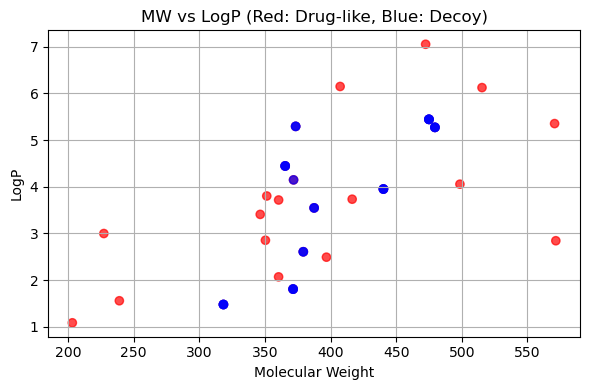

<Figure size 600x400 with 0 Axes>

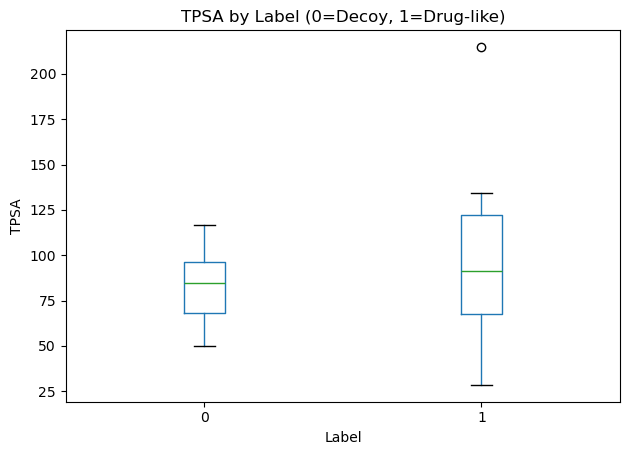

In [27]:
# Importing libraries
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Function to extract features from a single molecule
def extract_ligand_features(mol, label):
    try:
        mol_name = mol.GetProp('_Name') #Gets name
        mol_weight = Descriptors.MolWt(mol) #Gets molecular weight
        logp = Descriptors.MolLogP(mol) #Gets lipophilicity
        h_bond_donors = rdMolDescriptors.CalcNumHBD(mol) # Counts H-bond donors
        h_bond_acceptors = rdMolDescriptors.CalcNumHBA(mol) #Counts H-bond acceptors
        rot_bonds = Descriptors.NumRotatableBonds(mol) #Counts single bond that can rotate freely
        tpsa = rdMolDescriptors.CalcTPSA(mol) # Topological surface area calculator 
        # Atom encoding: Counting each atom (from a selected list) in molecule 
        atom_counts = {}
        for atom in mol.GetAtoms(): #Parse through each atom of the molecule
            symbol = atom.GetSymbol() #Gets symbol of atom 
            if symbol not in atom_counts: #If atom not in dict, initialize the key with 0
                atom_counts[symbol] = 0
            atom_counts[symbol] += 1 #If present, count is increased by 1

        features = {
            "Name": mol_name,
            "MW": mol_weight,
            "LogP": logp,
            "HBD": h_bond_donors,
            "HBA": h_bond_acceptors,
            "RB": rot_bonds,
            "TPSA": tpsa,
            "Label": label
        }

        for atom in ['C', 'H', 'N', 'O', 'F', 'Cl', 'Br', 'S', 'P']: #loop through the length of these pre-defined Elements to add key of each element and their count
            features[f'Num_{atom}'] = atom_counts.get(atom, 0)

        return features #return a dict

    except:
        print("Invalid data entry")

# Function to process an SDF file
def process_sdf_file(sdf_file, label):
    file = Chem.SDMolSupplier(sdf_file) #load the sdf file into a variable
    data = [] #List to add all the "features" dicts in the file

    for i in file:
        result = extract_ligand_features(i, label) #Applies the function on each molecule in the file
        if result:
            data.append(result) #Creates a list of dicts

    df = pd.DataFrame(data) #converting into dataframe 
    return df

# Main function
def main():
    drug_like = "Drug_like.sdf"
    non_drug_like = "Drug_decoys.sdf"

    #Separately read sdf files for drug like and non drug like files
    drug_df = process_sdf_file(drug_like, label=1) 
    decoy_df = process_sdf_file(non_drug_like, label=0)
    
    #Concatenate both dataframes 
    final_df = pd.concat([drug_df, decoy_df], ignore_index=True)
    
    #output stored in csv file
    final_csv = final_df.to_csv("ligand_features_dataset.csv", index=False)
    
    print(f"Dataset created with {len(final_df)} molecules")
    print("First few rows:")
    print(final_df.head())
    
    #Divide into features and labels:
    # Drop both Name and Label columns for features
    X = final_df.drop(["Name", "Label"], axis=1)
    y = final_df["Label"]
    # Logistic Regression
    print("LOGISTIC REGRESSION RESULTS")
    # Scale the features (important for logistic regression)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split the data into train/test
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=30)

    # Define the model
    model = LogisticRegression(random_state=30)

    # Model fitting
    model.fit(X_train, y_train)

    # Predicting
    y_pred = model.predict(X_test)

    # Model evaluation
    print("Confusion matrix for Logistic Regression:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report for Logistic Regression:")
    print(classification_report(y_test, y_pred))
    print("\nAccuracy score for Logistic Regression:", accuracy_score(y_test, y_pred))
    
    # Scatter Plot: Molecular Weight vs LogP
    plt.figure(figsize=(6, 4))
    plt.scatter(final_df['MW'], final_df['LogP'], c=final_df['Label'], cmap='bwr', alpha=0.7)
    plt.xlabel("Molecular Weight")
    plt.ylabel("LogP")
    plt.title("MW vs LogP (Red: Drug-like, Blue: Decoy)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Box Plot: TPSA by Label
    plt.figure(figsize=(6, 4))
    final_df.boxplot(column='TPSA', by='Label', grid=False)
    plt.title("TPSA by Label (0=Decoy, 1=Drug-like)")
    plt.suptitle("")  # Remove default subtitle
    plt.xlabel("Label")
    plt.ylabel("TPSA")
    plt.tight_layout()
    plt.show()
    

# Run the main function
if __name__ == "__main__":
    main()